## Importing all the Required Libraries

In [1]:
# For data reading, processing and manipulation
import pandas as pd
import numpy as np

#For data plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#For splitting the data into train and test sets.
from sklearn.model_selection import train_test_split

#For preprocessing the data, using MinMax Scaling.
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#For feature selection
from sklearn.feature_selection import RFE

#For checking multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

#For creating the Linear Regression model, using statsmodels and sklearn
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

#For calculating the error metric (R2 Score).
from sklearn.metrics import r2_score

In [2]:
#Reading the data and checking the top 5 rows.
data = pd.read_csv('day.csv')
data.head(8)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
5,6,06-01-2018,1,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,88,1518,1606
6,7,07-01-2018,1,0,1,0,5,1,2,8.057402,10.44195,49.8696,11.304642,148,1362,1510
7,8,08-01-2018,1,0,1,0,6,0,2,6.765000,8.11270,53.5833,17.875868,68,891,959


- Each row corresponds to one day.
- The data is present for two years 2018 and 2019 for 365 days of each year.
- Sunday is designated as 0 in workingday.

In [3]:
#Checking the shape/size of the data
print("Number of rows:",data.shape[0], "and number of columns:", data.shape[1])

Number of rows: 730 and number of columns: 16


In [4]:
#Checking the datatypes of the columns and the number of Null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


- **dteday:** Date column.
- **season:** determines the season.
- **yr:** stands for year, 0 for 2018 and 1 for 2019.
- **mnth:** stands for the month of the year.
- **holiday:** flag, determines whether the day was a holiday or not.
- **weekday:** stands for the day of the week, 0 for Sunday, 1 for Monday and so on.
- **workingday:** flag, determines whether the day was a weekday(1) or a weekend(0).
- **weathersit:** stands for the weather situation.
- **temp:** the temperature in Celsius.
- **atemp:** feels like temperature in Celsius.
- **hum:** humidity.
- **casual:** number of casual users.
- **registered:** number of registered users.
- **count:** total number of bike rentals (casual + registered).

In [5]:
#Some of the column names are not named properly, therefore it is imperative to change them.
rename_map = {
    'dteday':'date',
    'yr':'year',
    'mnth':'month',
    'atemp':'feels_like',
    'hum':'humidity',
    'cnt':'count'
}

data.rename(columns = rename_map, inplace = True)

There are no Null entries in the dataset. However we see the column 'dteday' is an object and must be converted to the datetime format.

In [6]:
#Converting the dteday to datetime format.
data['date'] = pd.to_datetime(data['date'], dayfirst = True)

In [7]:
# We observe that the instant column is an index column and is not a feature. Therefore it can be dropped.
columns_to_drop = ['instant']
# There might be more columns that we wish to drop at later stages, 
# they will be appended to the list and the desired columns will be dropped

In [8]:
#Mapping the season values to their descriptive values.
season_map = {
    1: 'spring',
    2: 'summer',
    3: 'autumn',
    4: 'winter'
}
data['season'] = data['season'].map(season_map)

In [9]:
#Mapping the weathersit values to their descriptive values.
weathersit_map = {
    1: 'clear_partly_cloudy',
    2: 'mist_few_clouds',
    3: 'light_preci_thunderstorm',
    4: 'heavy_preci_thunderstorm_fog'
}
data['weathersit'] = data['weathersit'].map(weathersit_map)

In [10]:
year_map = {
    0 : 2018,
    1 : 2019
}

data['year'] = data['year'].map(year_map)
#Since we see the values 0 and 1 in the year column, they seem already scaled using MinMax Scaler, 
# however, it is important to use MinMaxScaler on it, so that we can convert the test data accordingly to the appropriate value
# if some data outside of the 2018 or 2019 is provided to predict.

In [11]:
def get_quarter(x):
    if x >= 1 and x <= 3:
        return "Q1"
    elif x >= 4 and x <= 6:
        return "Q2"
    elif x >= 7 and x <= 9:
        return "Q3"
    else:
        return "Q4"
    
data['quarter'] = data['month'].apply(lambda x: get_quarter(x))

In [12]:
# Since the registered and casual users in a split of the target(cnt) and therefore we can drop these. 
# These variables are a breakdown of the target and therefore cannot be considered as independent variables.
#Adding the column dteday to the list of the columns to be dropped, since this column cannot be used as a feature.
columns_to_drop.extend(['casual', 'registered', 'date'])

In [13]:
data.weathersit.value_counts()

clear_partly_cloudy         463
mist_few_clouds             246
light_preci_thunderstorm     21
Name: weathersit, dtype: int64

In [14]:
data.season.value_counts()

autumn    188
summer    184
spring    180
winter    178
Name: season, dtype: int64

For the two years data, there is no weather situation labelled as **Heavy Precipitation/Thunderstorm/Fog**

## Performing EDA

In [15]:
def plot_univariate_numerical_boxplot(data, columns):
    num_plots = len(columns)
    num_rows = (num_plots + 1) // 2
    
    fig, axes = plt.subplots(num_rows, 2, figsize = (12, 6 * num_rows))
    
    for i, column in enumerate(columns):
        row = i // 2
        col = i % 2
        
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.boxplot(data[column])
        ax.set_title(column)
        
    plt.tight_layout()
    plt.show()

**Decoding Boxplots**
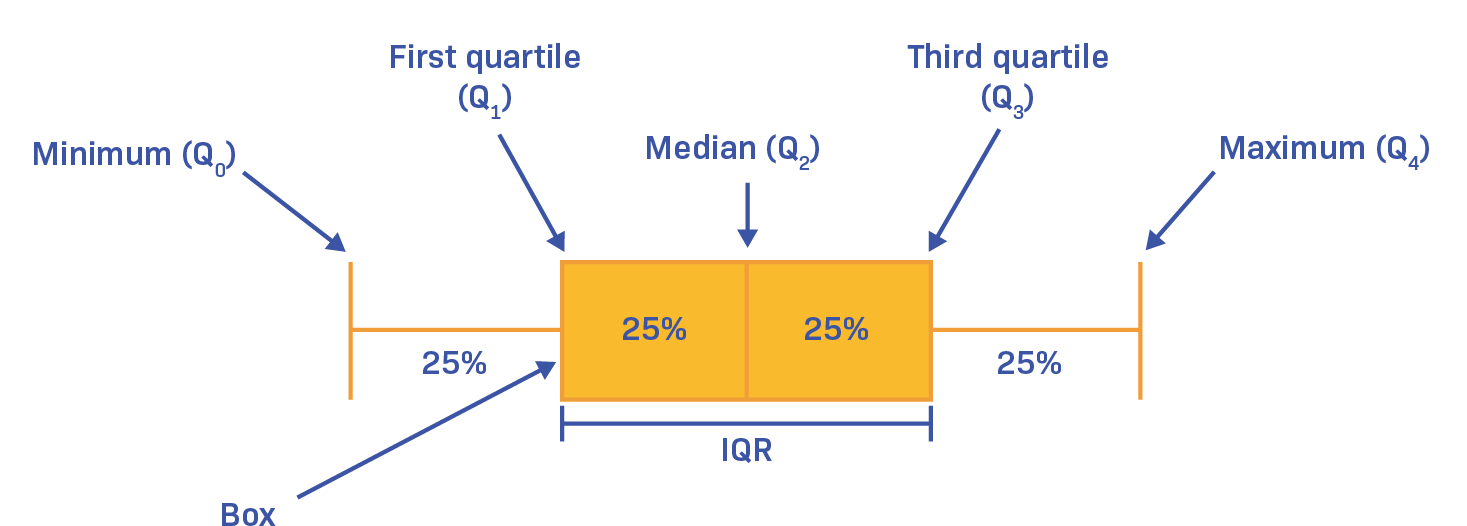

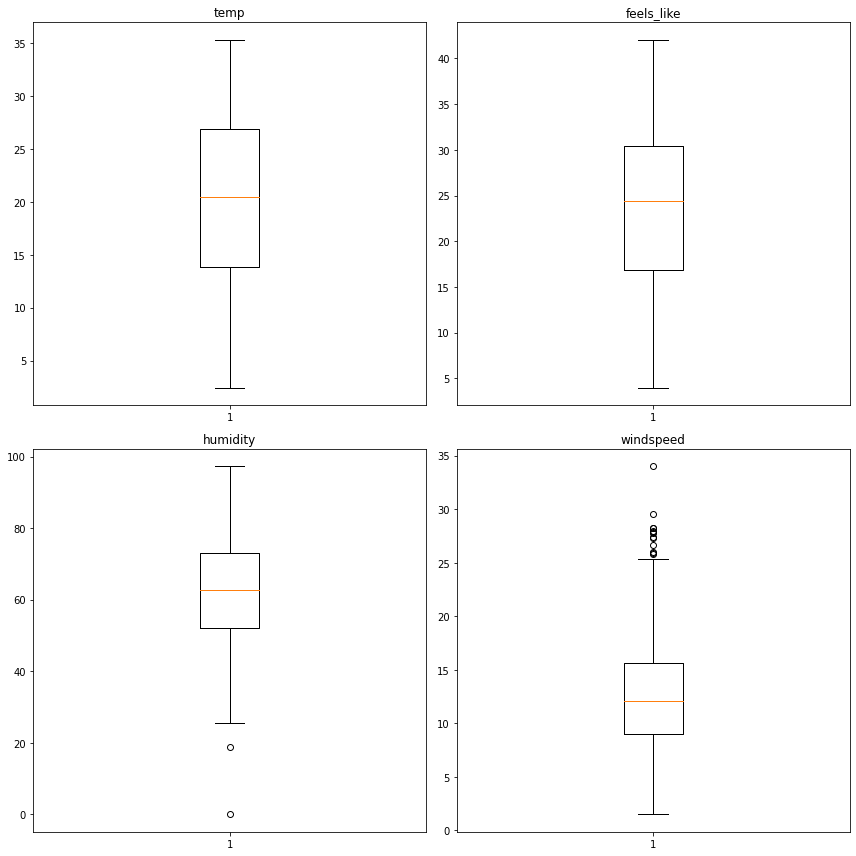

In [16]:
plot_univariate_numerical_boxplot(data, ['temp', 'feels_like', 'humidity', 'windspeed'])

We see that the data does not contain significant outliers, there are some outliers in windspeed, but they are within the expected range, since there are some days of the year when it is too windy.

In [17]:
data.groupby(['year']).holiday.sum()

year
2018    10
2019    11
Name: holiday, dtype: int64

There are a total of 21 holidays, out of which 10 were in 2018 and 11 in 2019. The difference between the holiday distribution is not significant.

In [18]:
def plot_bivariate_barplots(data, columns):
    num_plots = len(columns)
    num_rows = (num_plots + 1) // 2
    
    fig, ax = plt.subplots(num_rows, 2, figsize = (14, 6 * num_rows))
    
    ax = ax.flatten()
    
    for i, column in enumerate(columns):
        
        sns.barplot(data = data, x = column, y = 'count', ax = ax[i])
        ax[i].bar_label(ax[i].containers[-1], fmt='%.1f', label_type='center')
        ax[i].set_title(column)
        ax[i].set_xlabel('')
        for tick in ax[i].get_xticklabels():
            tick.set_rotation(75)

    for j in range(num_plots, len(ax)):
            ax[j].axis('off')
        
    plt.tight_layout()
    plt.show()

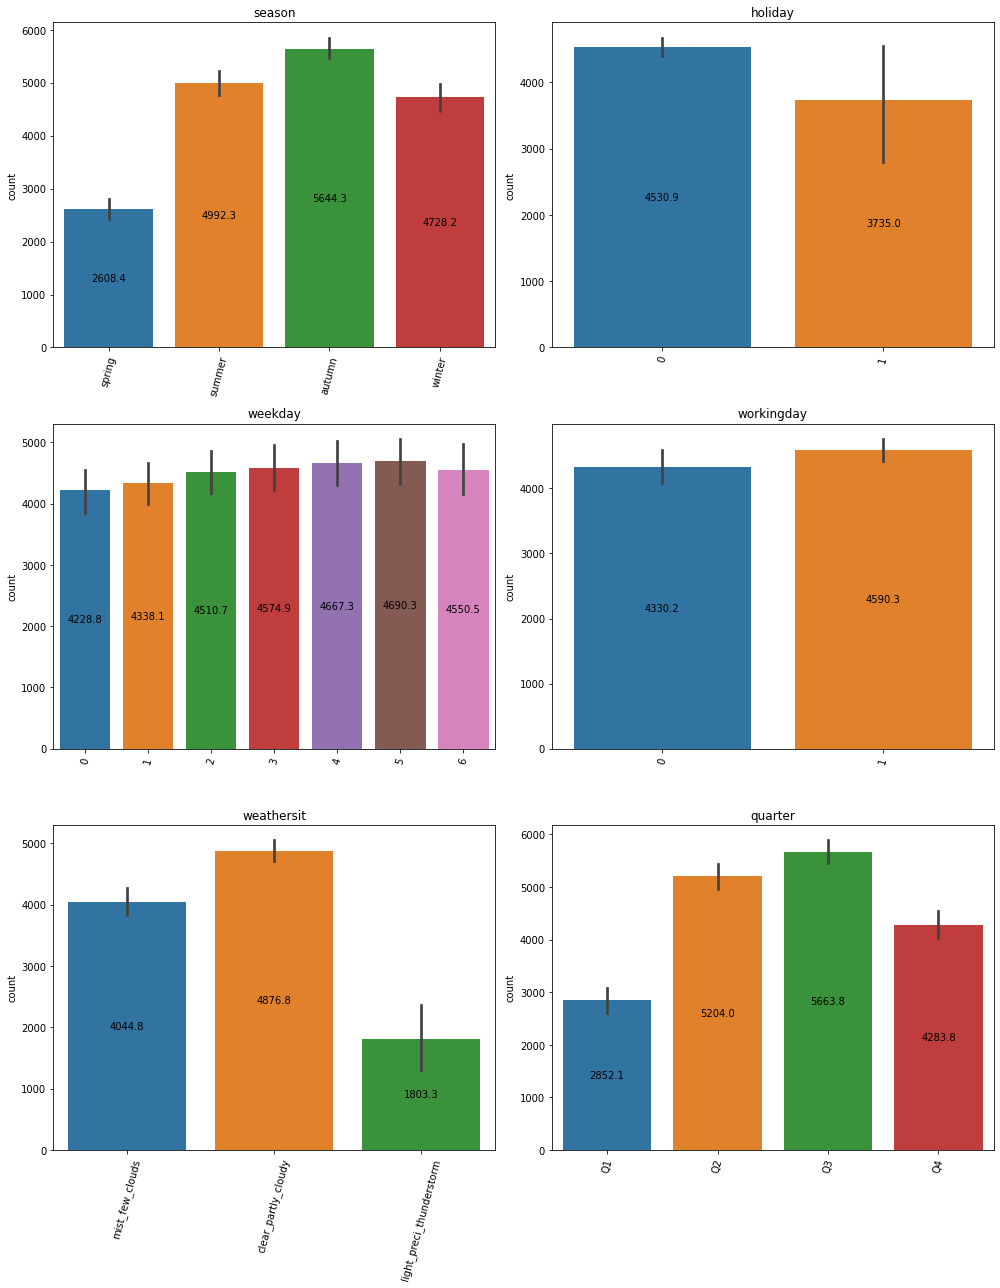

In [19]:
plot_bivariate_barplots(data, ['season', 'holiday', 'weekday', 'workingday','weathersit', 'quarter'])

Insights:
- The demand is the lowest in Spring, while it is the highest in Autumn.
- The demand is considerably higher on non-holidays than the holidays.
- The demand is fairly similar on most days of the week.
- There does not seem to be a significant difference in demand during weekdays as opposed to weekends.
- Weather situation does seem to have a significant impact on demand, with Light Precipitation having significantly least demand.
- The quarter follows a similar trend as the season.

In [20]:
def plot_lineplot(data, x, y, hue, title, palette = 'RdBu_r'):
    plt.figure(figsize = (18,6))
    sns.lineplot(x = x, y = y, data = data, hue = hue, palette = palette)
    plt.title(title, fontsize = 15)
    plt.show()

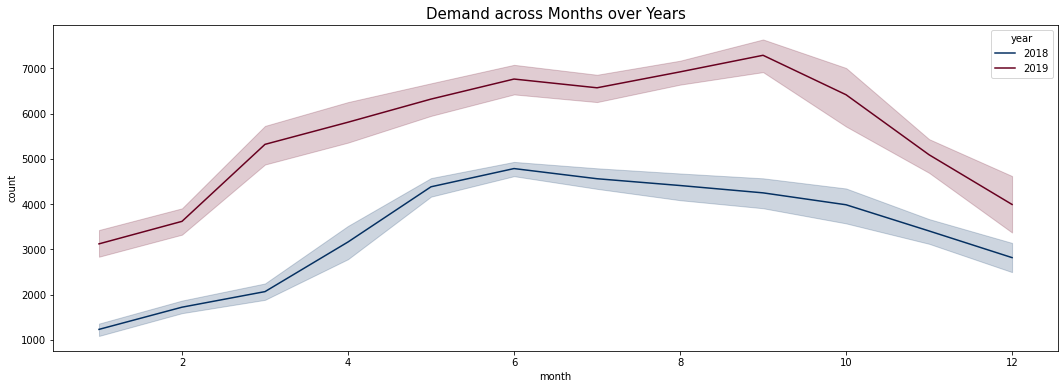

In [21]:
#Let us see check some hypotheses using plots.
# If there is increase in the demand in 2019 as compared to 2018 for the same month.
plot_lineplot(data, 'month', 'count', 'year', 'Demand across Months over Years')

We can see observable increase in demand for 2019 for the same month as compared to 2018.

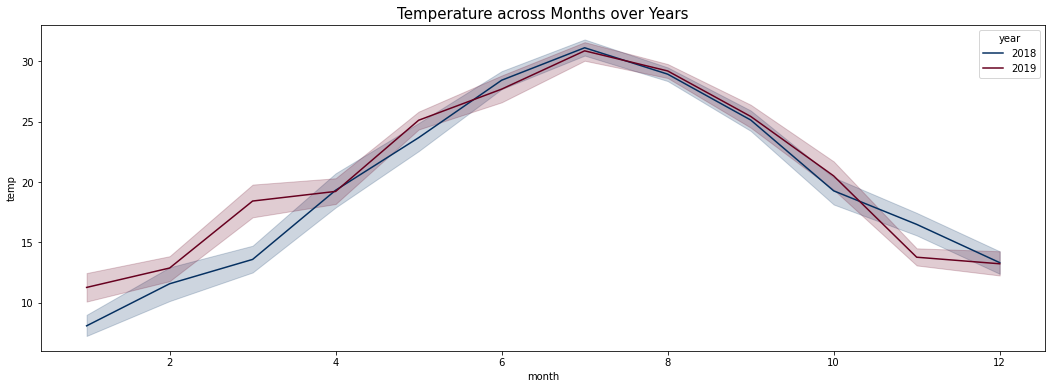

In [22]:
plot_lineplot(data, 'month', 'temp', 'year', 'Temperature across Months over Years')

The distribution of the temperature is similar for both years, though it is very normal to see some deviations.

## Creating dummy variables and dropping the columns that are not required

In [23]:
# Creating the dummy variables of the categorical column season while also dropping the first category, since 4
# categories in season can be represented using 3 levels.

data = pd.get_dummies(data, columns = ['season', 'weathersit', 'quarter'], drop_first = True)

In [24]:
data.head()

,instant,date,year,month,holiday,weekday,workingday,temp,feels_like,humidity,...,registered,count,season_spring,season_summer,season_winter,weathersit_light_preci_thunderstorm,weathersit_mist_few_clouds,quarter_Q2,quarter_Q3,quarter_Q4
0,1,2018-01-01,2018,1,0,6,0,14.110847,18.18125,80.5833,...,654,985,1,0,0,0,1,0,0,0
1,2,2018-01-02,2018,1,0,0,0,14.902598,17.68695,69.6087,...,670,801,1,0,0,0,1,0,0,0
2,3,2018-01-03,2018,1,0,1,1,8.050924,9.47025,43.7273,...,1229,1349,1,0,0,0,0,0,0,0
3,4,2018-01-04,2018,1,0,2,1,8.200000,10.60610,59.0435,...,1454,1562,1,0,0,0,0,0,0,0
4,5,2018-01-05,2018,1,0,3,1,9.305237,11.46350,43.6957,...,1518,1600,1,0,0,0,0,0,0,0


In [25]:
numerical_columns = ['temp', 'feels_like', 'humidity', 'windspeed']

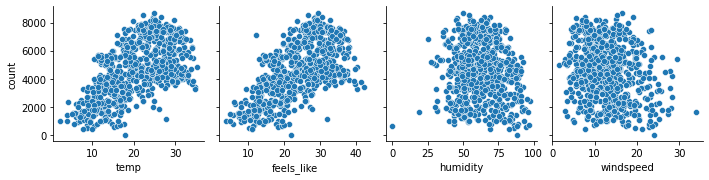

In [26]:
#Checking the numerical-numerical plot, to see whether the linear relationship exists between some variables and the target(count).
sns.pairplot(data, x_vars = numerical_columns, y_vars = 'count')
plt.show()

There seems to be a strong positive linear relationship of the target with temp and feels_like(atemp), however the linear relationship is not there with humidity, windspeed and day.

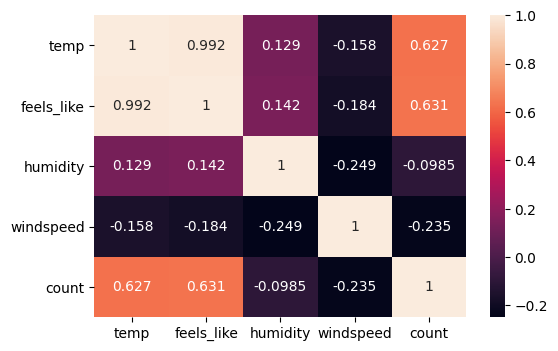

In [27]:
plt.figure(dpi = 100)
sns.heatmap(data[numerical_columns + ['count']].corr(), annot = True, fmt = ".3g")
plt.show()

The findings from the pair-plot are validated from the heatmap. The temp and feels_like have a moderately strong positive correlation with the target(count).

We observe that the feels_like and temp have a near perfect positive correlation coefficient (0.99), this is expected. However, we must drop either of the two variables, to address multicollinearity. Even though multicollinearity will be checked later as well, since it may not always be apparent using the correlation coefficient, but it is imperative that we drop either of the two now as the correlation coefficient of 0.99 indicates that feels_like can be directly estimated using temp.

Let us keep the temp and drop the feels_like (atemp) column.

In [28]:
#Dropping the columns that need to be
columns_to_drop.extend(['feels_like', 'month', 'weekday'])
print(columns_to_drop)
data.drop(columns = columns_to_drop, axis = 1, inplace = True)

['instant', 'casual', 'registered', 'date', 'feels_like', 'month', 'weekday']


## Splitting the data into the train and test sets.

In [29]:
# Splitting the data into independent (X) and dependent (y) sets.
# Converting the count/target to thousands so that we have scaled coefficients.
y = data[['count']]/1000
X = data[[col for col in data.columns if col != 'count']]

In [30]:
#Splitting into train and test sets using the test size = 0.25.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

## Rescaling the features

In [31]:
mm_scaler = MinMaxScaler()

#Using fit_transform on the train set to learn and also transform the data
X_train[['year','temp','humidity','windspeed']] = mm_scaler.fit_transform(X_train[['year','temp','humidity','windspeed']])

#Using transform on the test set to transform the data using the learned parameters from the train set.
X_test[['year','temp','humidity','windspeed']] = mm_scaler.transform(X_test[['year','temp','humidity','windspeed']])

## Model 1: Model without using any feature selection.

In [32]:
def create_linear_model_and_vif_analysis(X_train, X_test, y_train, y_test, drop_col = False):
    
    if drop_col:
        X_train.drop(drop_col, axis = 1, inplace = True)
        X_test.drop(drop_col, axis = 1, inplace = True)
    
    #Adding the constant and creating the linear model.
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    
    X_test = sm.add_constant(X_test)
    
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    #Finding the R2 score on train and test sets.
    print("R2 Score on Train Data:", round(r2_score(y_train, train_preds), 3))
    print("R2 Score on Test Data:", round(r2_score(y_test, test_preds), 3))
    print(model.summary())
    
    vif = pd.DataFrame()
    X = X_train.drop('const', axis = 1)
    vif['Features'] = X.columns
    vif['VIF'] = [round(variance_inflation_factor(X.values, i), 3) for i in range(X.shape[1])]
    vif.sort_values(by = 'VIF', ascending = False, inplace = True)
    
    return model, vif, train_preds, test_preds

In [33]:
model_1, vif_1, train_preds_1, test_preds_1 = create_linear_model_and_vif_analysis(X_train, X_test, y_train, y_test)

R2 Score on Train Data: 0.824
R2 Score on Test Data: 0.824
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     177.3
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          7.01e-190
Time:                        17:59:28   Log-Likelihood:                -664.17
No. Observations:                 547   AIC:                             1358.
Df Residuals:                     532   BIC:                             1423.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

### Key observations
1. R2 value = 0.824 and adjusted-R2 value: 0.819.
2. Prob. F-statistic is very low and much less than 0.05, indicating the model is a good fit overall.
3. The following variables have a high p-value (>0.05) (quarter_Q3: 0.488, quarter_Q2: 0.454, season_summer: 0.219).

In [34]:
vif_1[vif_1['VIF'] >= 5]

,Features,VIF
4,humidity,30.039
3,temp,22.580
12,quarter_Q3,9.859
11,quarter_Q2,9.187
8,season_winter,7.832
13,quarter_Q4,7.716
7,season_summer,6.793
6,season_spring,5.981
5,windspeed,5.875


VIF of >= 5 must be investigated

For feature selection after creating a model using all possible set of features, we look at p-values and the VIF values.
p-value indicates the significance of the feature, whereas VIF indicates how well the feature is explained/predicted by other independent features.
p-values < 0.05 and VIF < 5 are desirable.
To select a feature, we remove the columns one by one using the following heuristic:
1. Remove the column with high p-value and high VIF value.
2. Remove the column with high p-value and low VIF value.
3. Remove the column with low VIF and high p-value.
4. Remove the column with low VIF and low p-value.

Note that we should investigate/remove only those columns where p-value >= 0.05 and/or VIF >= 5.
Also each of the steps above must be performed as long as the columns satisfying the condition exists.
We must also drop the columns one by one and the re-check the p-values and the VIF values, since dropping the column will result in changes in both of these values.

Dropping quarter_Q3, since it has high p-value and high VIF.

## Model 2: Model without the feature "quarter_Q3"

In [35]:
model_2, vif_2, train_preds_2, test_preds_2 = create_linear_model_and_vif_analysis(X_train, X_test, y_train, y_test, ['quarter_Q3'])

R2 Score on Train Data: 0.823
R2 Score on Test Data: 0.827
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     191.1
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          6.31e-191
Time:                        17:59:28   Log-Likelihood:                -664.41
No. Observations:                 547   AIC:                             1357.
Df Residuals:                     533   BIC:                             1417.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [36]:
vif_2[vif_2['VIF'] >= 5]

,Features,VIF
4,humidity,26.395
3,temp,16.142
8,season_winter,7.208
12,quarter_Q4,6.160
7,season_summer,6.128
11,quarter_Q2,5.681
5,windspeed,5.540


Dropping **quarter_Q2** as it has a high p-value.

## Model 3: Model without the feature "quarter_Q2"

In [37]:
model_3, vif_3, train_preds_3, test_preds_3 = create_linear_model_and_vif_analysis(X_train, X_test, y_train, y_test, ['quarter_Q2'])

R2 Score on Train Data: 0.823
R2 Score on Test Data: 0.827
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     207.3
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          4.64e-192
Time:                        17:59:28   Log-Likelihood:                -664.49
No. Observations:                 547   AIC:                             1355.
Df Residuals:                     534   BIC:                             1411.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [38]:
vif_3[vif_3['VIF'] >= 5]

,Features,VIF
4,humidity,26.078
3,temp,15.420
8,season_winter,7.199
11,quarter_Q4,6.152
5,windspeed,5.535


Dropping **humidity** as it has highest VIF.

## Model 4: Model without the feature "humidity"

In [39]:
model_4, vif_4, train_preds_4, test_preds_4 = create_linear_model_and_vif_analysis(X_train, X_test, y_train, y_test, ['humidity'])

R2 Score on Train Data: 0.82
R2 Score on Test Data: 0.819
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     221.6
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          4.25e-191
Time:                        17:59:28   Log-Likelihood:                -669.57
No. Observations:                 547   AIC:                             1363.
Df Residuals:                     535   BIC:                             1415.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [40]:
vif_4

,Features,VIF
7,season_winter,6.559
10,quarter_Q4,6.045
4,windspeed,5.530
3,temp,5.174
2,workingday,3.256
5,season_spring,2.170
0,year,2.083
6,season_summer,1.869
9,weathersit_mist_few_clouds,1.559
1,holiday,1.112


Dropping **season_winter** as it has highest VIF.

## Model 5: Model without the feature "season_winter"

In [41]:
model_5, vif_5, train_preds_5, test_preds_5 = create_linear_model_and_vif_analysis(X_train, X_test, y_train, y_test, ['season_winter'])

R2 Score on Train Data: 0.81
R2 Score on Test Data: 0.811
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     228.5
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          5.06e-186
Time:                        17:59:28   Log-Likelihood:                -684.38
No. Observations:                 547   AIC:                             1391.
Df Residuals:                     536   BIC:                             1438.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [42]:
vif_5

,Features,VIF
4,windspeed,5.440
3,temp,5.174
2,workingday,3.203
0,year,2.077
5,season_spring,1.910
6,season_summer,1.781
9,quarter_Q4,1.622
8,weathersit_mist_few_clouds,1.554
1,holiday,1.112
7,weathersit_light_preci_thunderstorm,1.095


Dropping **season_summer** as it has highest p-value.

## Model 6: Model without the feature "season_summer"

In [43]:
model_6, vif_6, train_preds_6, test_preds_6 = create_linear_model_and_vif_analysis(X_train, X_test, y_train, y_test, ['season_summer'])

R2 Score on Train Data: 0.81
R2 Score on Test Data: 0.811
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     254.3
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          3.09e-187
Time:                        17:59:28   Log-Likelihood:                -684.38
No. Observations:                 547   AIC:                             1389.
Df Residuals:                     537   BIC:                             1432.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [44]:
vif_6

,Features,VIF
3,temp,5.174
4,windspeed,4.769
2,workingday,3.154
0,year,2.068
5,season_spring,1.656
7,weathersit_mist_few_clouds,1.533
8,quarter_Q4,1.394
1,holiday,1.109
6,weathersit_light_preci_thunderstorm,1.095


Dropping **quarter_Q4** as it has highest p-value.

## Model 7: Model without the feature "quarter_Q4"

In [45]:
model_7, vif_7, train_preds_7, test_preds_7 = create_linear_model_and_vif_analysis(X_train, X_test, y_train, y_test, ['quarter_Q4'])

R2 Score on Train Data: 0.81
R2 Score on Test Data: 0.811
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     286.2
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          2.54e-188
Time:                        17:59:28   Log-Likelihood:                -684.76
No. Observations:                 547   AIC:                             1388.
Df Residuals:                     538   BIC:                             1426.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [46]:
vif_7

,Features,VIF
3,temp,5.026
4,windspeed,4.561
2,workingday,3.064
0,year,2.019
5,season_spring,1.587
7,weathersit_mist_few_clouds,1.510
1,holiday,1.078
6,weathersit_light_preci_thunderstorm,1.078


p-values and VIFs of the independent variables are within the acceptable limits and therefore model_7 is the final model, where R2 score on train data = 0.81 and R2 score on test data = 0.811

## Validating Linear Regression Assumptions and analysing the predictions

Since we see above that VIF for all features is less than 5 and therefore multicollinearity has been addressed.

In [47]:
#Let us get a visual view of our actual values v/s predicted values across dates

data['date'] = pd.date_range(start = '2018-01-01', end = '2019-12-31')

train_pred_df = pd.concat([y_train, train_preds_7], axis = 1).rename(columns = {'count':'actual',
                                                               0:'predicted'})
train_pred_df['label'] = 'train'

test_pred_df = pd.concat([y_test, test_preds_7], axis = 1).rename(columns = {'count':'actual',
                                                               0:'predicted'})
test_pred_df['label'] = 'test'

In [48]:
pred_df = pd.concat([train_pred_df, test_pred_df])
pred_df = pred_df.merge(data['date'], left_index = True, right_index = True, how = 'inner')
pred_df.sort_values(by = 'date', inplace = True)

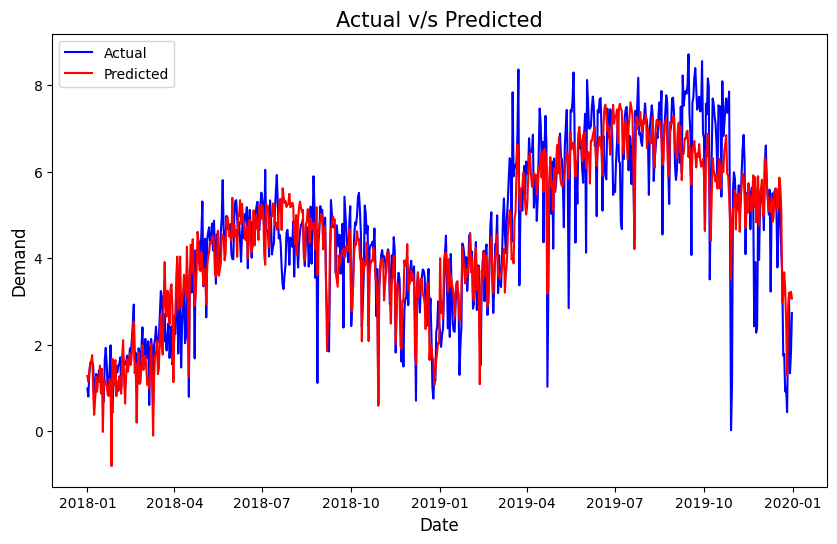

In [49]:
fig = plt.figure(figsize = (10,6), dpi = 100)
plot1 = sns.lineplot(x = pred_df['date'], y = pred_df['actual'], color="blue")
plot2 = sns.lineplot(x = pred_df['date'], y = pred_df['predicted'], color="red")
plt.title('Actual v/s Predicted', fontsize=15)      
plt.xlabel('Date', fontsize=12)                    
plt.ylabel('Demand', fontsize=12)
plt.legend(['Actual', 'Predicted'])
plt.show()

We can see that the model has done a fairly good job of predicting the demand, note that some of these are train predictions and some are test predictions, both are combined to give a better look of the predictions over dates without any missing dates.

In [50]:
# Let us validate the assumption about the normality of the residuals

import scipy.stats as stats

def qq_plot_residuals(y_train, train_preds):
    
    residuals = y_train['count'] - train_preds

    # Calculate the quantiles of the residuals
    sorted_residuals = np.sort(residuals)
    
    plt.rc("figure", figsize=(10,6), dpi = 80)
    sm.qqplot(sorted_residuals, line = 'q')

    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sorted Residuals')
    plt.title('Q-Q Plot of Residuals')
    plt.show()

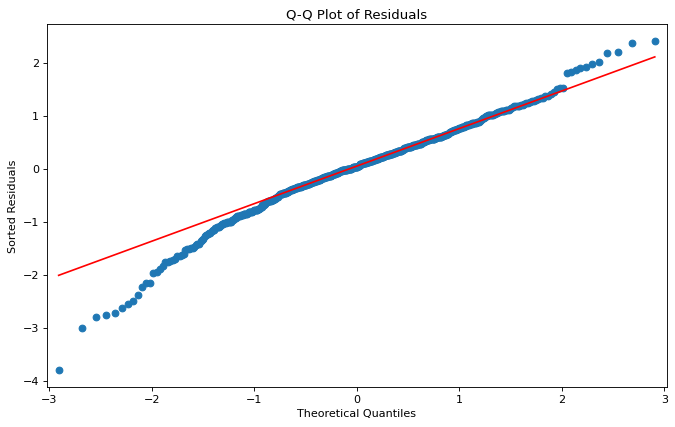

In [51]:
#Plotting Q-Q plot on residuals
qq_plot_residuals(y_train, train_preds_7)

We observe that the theoretical quantiles and the residual quantiles almost form an overlapping straight line which point to the fact that the residuals are normally distributed, let us also validate the same using a distribution plot.

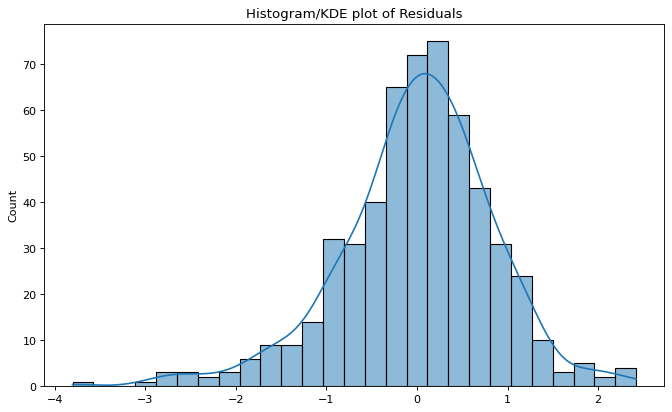

In [52]:
plt.figure(figsize=(10,6), dpi = 80)
sns.histplot(model_7.resid, kde = True)
plt.title('Histogram/KDE plot of Residuals')
plt.show()

The distribution matches closely to that of the normal distribution, though we see some skewness but the overall distribution is fairly normal.

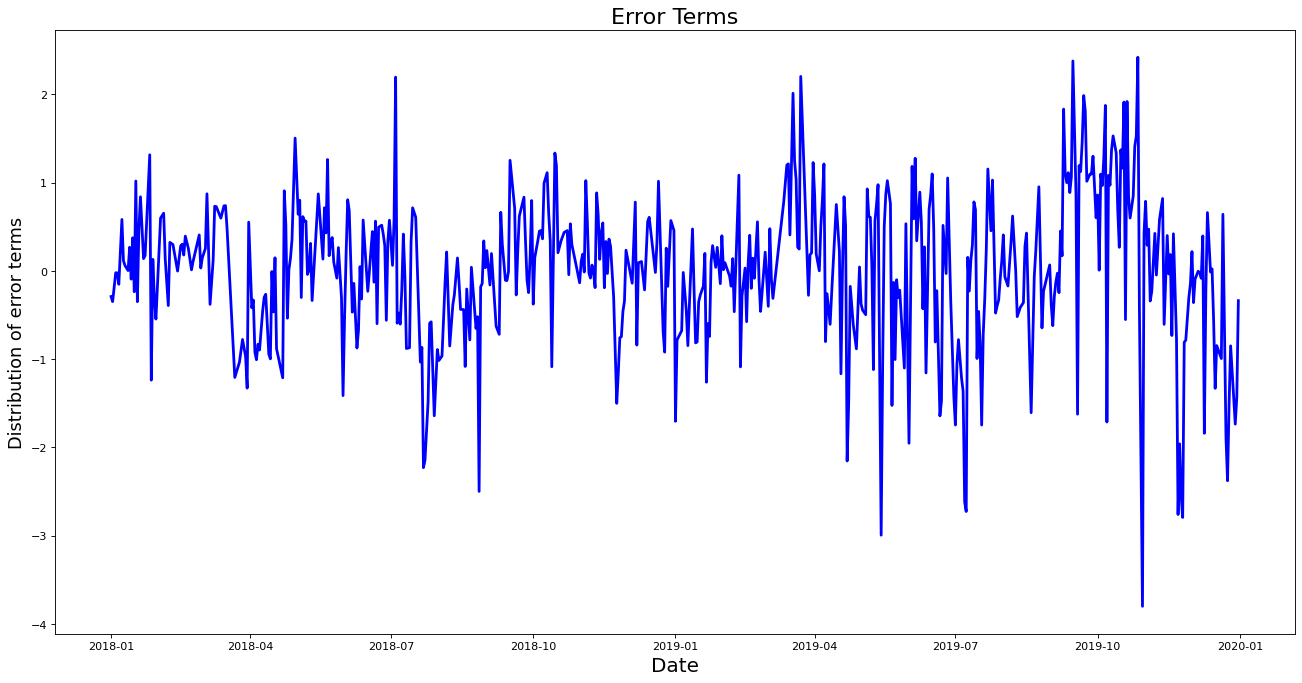

In [53]:
training_preds = pred_df[pred_df['label'] == 'train']
fig = plt.figure(figsize = (20, 10))
plt.plot(training_preds['date'], training_preds['actual'] - training_preds['predicted'], color="blue", linewidth=2.5, linestyle="-")
plt.title('Error Terms', fontsize=20)      
plt.xlabel('Date', fontsize=18)                      
plt.ylabel('Distribution of error terms', fontsize=16)   
plt.show()

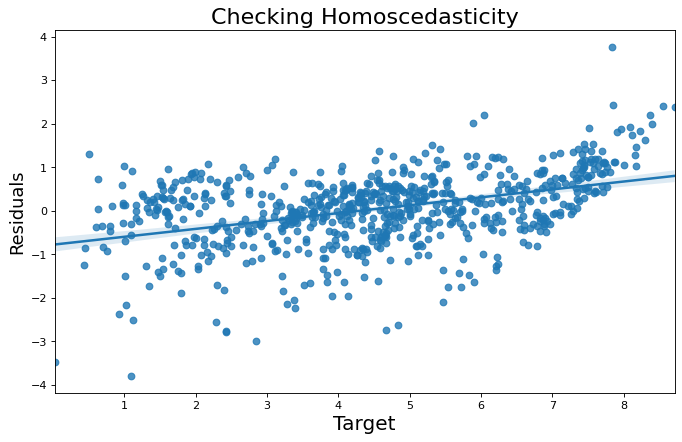

In [54]:
fig = plt.figure(figsize = (10, 6))
sns.regplot(x = pred_df['actual'], y = pred_df['actual'] - pred_df['predicted'])
plt.title('Checking Homoscedasticity', fontsize=20)      
plt.xlabel('Target', fontsize=18)                      
plt.ylabel('Residuals', fontsize=16)   
plt.show()

The plot of Residuals v/s Target does not reveal any apparent heteroscedasticity.

Therefore the model_8 is our best fit model for the data

In [55]:
#Getting the model parameters
model_7.params

const                                  2.762907
year                                   2.055765
holiday                               -0.598456
workingday                             0.195542
temp                                   2.956889
windspeed                             -0.896239
season_spring                         -1.583972
weathersit_light_preci_thunderstorm   -2.156991
weathersit_mist_few_clouds            -0.642688
dtype: float64

The equation of the best fitted line is therefore (ordered from largest to smallest):

$$ count(target) = 2.763 + 2.957 * temp + 2.05 * year + 0.196 * workingday - 0.599 * holiday - 0.643 * weathersit\_mist\_few\_clouds - 0.896 * windspeed - 1.584 * season\_spring - 2.16 * weathersit\_light\_preci\_thunderstorm $$

#### Final comments:

- The positive coefficients indicate that the target increase with increase in the variable value, whereas the negative coefficient indicates that the target decreases with increase in the variable and vice-versa.
- We can use RFE to select a set of features, though using p-value and VIF is also a suitable approach, and the number of features are not large enough to force the usage the RFE.
- We can use a non-linear model to achieve better R2 value.
- Can use cross validation to get better estimate of the error.